In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 6.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=ef580834c2e56e30fc429b7d839a4c895466a9026c28846a279ffeff9811a4fb
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas_datareader import data as wb
import yfinance as yf

print('Tensorflow   : {}'.format(tf.__version__))
print('Numpy   : {}'.format(np.__version__))

Tensorflow   : 2.6.0
Numpy   : 1.19.5


In [ ]:
start_date = datetime(2004, 9, 13)
end_date = datetime(2021, 7, 30)
tickers = ['GOOGL']

brk = yf.Ticker(tickers[0])

hist = brk.history(start= start_date,
                   end= end_date)
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-09-13,53.368366,54.259258,53.283283,53.803802,7844148,0,0.0
2004-09-14,53.778778,56.056057,53.448448,55.800800,10828960,0,0.0
2004-09-15,55.335335,57.172173,55.155155,56.056057,10713076,0,0.0
2004-09-16,56.226227,57.957958,55.880882,57.042042,9266324,0,0.0
2004-09-17,57.267265,58.803802,56.831833,58.803802,9472518,0,0.0
...,...,...,...,...,...,...,...
2021-07-23,2608.610107,2667.979980,2596.010010,2660.300049,2075300,0,0.0
2021-07-26,2666.570068,2684.739990,2646.030029,2680.699951,1528600,0,0.0
2021-07-27,2685.010010,2687.979980,2602.080078,2638.000000,2735500,0,0.0


##Feature Engineering

In [ ]:
df = pd.DataFrame()
df['Change_of_price'] = hist['Close'].diff()
n = 14

def RSI(n, df):
  up_df, down_df = df['Change_of_price'].copy(), df['Change_of_price'].copy()
  up_df, down_df = pd.DataFrame(up_df), pd.DataFrame(down_df)

  up_df.loc['Change_of_price'] = up_df.loc[(up_df['Change_of_price'] < 0, 'Change_of_price')] = 0
  down_df.loc['Change_of_price'] = down_df.loc[(down_df['Change_of_price'] > 0, 'Change_of_price')] = 0
  down_df['Change_of_price'] = down_df['Change_of_price'].abs()

  ewma_up = up_df['Change_of_price'].transform(lambda x: x.ewm(span= n).mean())
  ewma_down = down_df['Change_of_price'].transform(lambda x: x.ewm(span= n).mean())

  relative_strength = ewma_up / ewma_down
  relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

  return relative_strength_index

def SO(n, df):
  low_n, high_n = df['Low'].copy(), df['High'].copy()
  low_n, high_n = pd.DataFrame(low_n), pd.DataFrame(high_n)

  low_n = low_n['Low'].transform(lambda x: x.rolling(window= n).min())
  high_n = high_n['High'].transform(lambda x: x.rolling(window= n).max())

  so = 100 * ((df['Close'] - low_n) / (high_n - low_n))

  return so

def WILR(n, df):
  low_n, high_n = df['Low'].copy(), df['High'].copy()
  low_n, high_n = pd.DataFrame(low_n), pd.DataFrame(high_n)

  low_n = low_n['Low'].transform(lambda x: x.rolling(window= n).min())
  high_n = high_n['High'].transform(lambda x: x.rolling(window= n).max())

  wr = (-100) * ((high_n - df['Close']) / (high_n - low_n))

  return wr

def MACD(df):
  ema_26 = df['Close'].transform(lambda x: x.ewm(span= 26).mean())
  ema_12 = df['Close'].transform(lambda x: x.ewm(span= 12).mean())

  macd = ema_12 - ema_26
  ema = macd.ewm(span= 9).mean()

  return macd, ema

def PRC(n, df):
  prc = df['Close'].transform(lambda x: x.pct_change(periods= n))
  return prc

def OBV(df):
  volume = df['Volume']
  change = df['Close'].diff()

  pre_obv = 0
  obv_l = []

  for i,j in zip(change, volume):
    if i > 0:
      current_obv = pre_obv + j
    elif i < 0:
      current_obv = pre_obv - j
    else:
      current_obv = pre_obv
    pre_obv = current_obv
    obv_l.append(pre_obv)
  
  return pd.Series(obv_l, index= df.index)

In [ ]:
df['RSI'] = RSI(n, df)
df['SO'] = SO(n, hist)
df['WILR'] = WILR(n, hist)
df['MACD'], df['MACD_EMA'] = MACD(hist)
df['PRC'] = PRC(n, hist)
df['OBV'] = OBV(hist)
df['CLOSE'] = hist['Close'].values
df = df.dropna()
print(df.shape)

cols = list(df)[:]
print(cols)

df = df[cols].astype(float)

(4236, 9)
['Change_of_price', 'RSI', 'SO', 'WILR', 'MACD', 'MACD_EMA', 'PRC', 'OBV', 'CLOSE']


In [ ]:
X_train = df[df.index <= '2020-07-30'].copy()
X_test = df[df.index > '2020-07-30'].copy()
y_train = X_train['CLOSE'].copy()
y_test = X_test['CLOSE'].copy()

X_train = X_train.drop(['CLOSE'], axis=1)
X_test = X_test.drop(['CLOSE'], axis=1)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3985, 8) (251, 8)
(3985,) (251,)


In [ ]:
from sklearn.preprocessing import StandardScaler
tmp_sc = StandardScaler()

df = tmp_sc.fit_transform(df)

In [ ]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
Y_scaler = StandardScaler()

X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)
y_train, y_test = np.reshape(y_train, (-1,1)), np.reshape(y_test, (-1,1))

X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_train = Y_scaler.fit_transform(y_train)
y_test = Y_scaler.transform(y_test)
y_train, y_test = np.reshape(y_train, (-1)), np.reshape(y_test, (-1))

In [ ]:
def create_batches(df, n_future, n_past, dfy = None):
  X = []
  Y = []

  if isinstance(df, (np.ndarray)) and dfy is not None:
    for i in range(n_past, df.shape[0]):
      X.append(df[i - n_past:i])
      Y.append(dfy[i])
  else:
    for i in range(n_past, len(df) - n_future +1):
        X.append(df[i - n_past:i, 0:df.shape[1] - 1])
        Y.append(df[i + n_future - 1:i + n_future, -1])
  
  X, Y = np.array(X), np.array(Y)
  if Y.ndim == 1:
    Y = np.reshape(Y, (-1,1))
  print(f'X shape:  {X.shape}')
  print(f'Y shape:  {Y.shape}')
  return X, Y

In [ ]:
n_f = 1
n_p = 60

X, y = create_batches(df, n_f, n_p)

X shape:  (4176, 60, 8)
Y shape:  (4176, 1)


In [ ]:
X_train, y_train = create_batches(X_train, n_f, n_p, y_train)
X_test, y_test = create_batches(X_test, n_f, n_p, y_test)

X shape:  (3925, 60, 8)
Y shape:  (3925, 1)
X shape:  (191, 60, 8)
Y shape:  (191, 1)


##LRfinder

In [ ]:
import math
from keras.callbacks import LambdaCallback
import keras.backend as K

class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file
        initial_weights = self.model.get_weights()
        # self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)
        # self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def get_derivatives(self, sma=1):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma=1, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

##Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.8, 
                              patience=5, 
                              min_lr=0.001, 
                              verbose=1)

es = EarlyStopping(monitor='val_loss', 
                   mode='auto', 
                   verbose=1, 
                   patience=11)

lr = 0.005
opt = Adam(learning_rate= lr)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(30, activation='relu', return_sequences= True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(40, activation='relu', return_sequences= False)))
model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(70, activation='relu', return_sequences= False)))
# model.add(Dropout(0.4))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer= opt, loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 60, 60)            9360      
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 80)                32320     
_________________________________________________________________
dropout_5 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 81        
Total params: 41,761
Trainable params: 41,761
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
123/123 [==============================] - 86s 656ms/step - loss: 0.9266
Epoch 2/5
123/123 [==============================] - 78s 635ms/step - loss: 0.8511
Epoch 3/5
123/123 [==============================] - 40s 326ms/step - loss: 9.0769


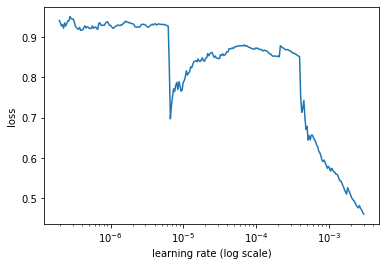

In [ ]:
bs = 32

lr_finder = LRFinder(model)
lr_finder.find(X_train, y_train, 
               start_lr=0.0000001, end_lr=100, batch_size= bs, epochs=5)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()

In [ ]:
for i, j in zip(lr_finder.losses, lr_finder.lrs):
  if i == lr_finder.best_loss:
    print(j)

0.0029917376


In [ ]:
#bs = 32
epochs = 50

history = model.fit(X_train, y_train, 
                    epochs= epochs, 
                    batch_size= bs, 
                    validation_split= 0.05, 
                    verbose= 1,
                    shuffle=False,
                    callbacks= [reduce_lr, es])

Epoch 1/50
117/117 [==============================] - 79s 640ms/step - loss: 1130709385216.0000 - val_loss: 9295299584.0000
Epoch 2/50
117/117 [==============================] - 75s 637ms/step - loss: 2716397469696.0000 - val_loss: 4269.0068
Epoch 3/50
117/117 [==============================] - 72s 618ms/step - loss: 7.1968 - val_loss: 1660.4292
Epoch 4/50
117/117 [==============================] - 71s 609ms/step - loss: 1.2890 - val_loss: 951.8007
Epoch 5/50
117/117 [==============================] - 71s 606ms/step - loss: 1.2849 - val_loss: 1196.6124
Epoch 6/50
117/117 [==============================] - 71s 608ms/step - loss: 1.0773 - val_loss: 2074.0393
Epoch 7/50
117/117 [==============================] - 71s 606ms/step - loss: 0.9748 - val_loss: 9591.2803
Epoch 8/50
117/117 [==============================] - 72s 611ms/step - loss: 1.0440 - val_loss: 5947.2417
Epoch 9/50
117/117 [==============================] - 73s 621ms/step - loss: 0.9091 - val_loss: 6375.9658

Epoch 00009: Red

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
# from pandas.tseries.holiday import USFederalHolidayCalendar
# from pandas.tseries.offsets import CustomBusinessDay
# us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# n_past = 16
# n_days_for_prediction=15  #let us predict past 15 days

# predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
# print(predict_period_dates)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = Y_scaler.inverse_transform(y_pred)
y_test = Y_scaler.inverse_transform(y_test)

In [ ]:
plt.figure(figsize= (14,5))
plt.plot(y_test, color= 'red', label= 'Real Google Stock Price')
plt.plot(y_pred, color= 'blue', label= 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()